# Crosscoders
Attempting to recreate the SAE model Anthropic wrote about recently.

Its a SAE which is layer and model agnostic.

I'm not sure about the model agnostic part, but I have an idea about layer the layer agnostic part.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM

from datasets import load_dataset

In [2]:
DEVICE = "mps"

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Coder-0.5B")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-Coder-0.5B").to(DEVICE)
model.eval()

tokens = tokenizer.encode("print(\"Hello", return_tensors="pt").to(DEVICE)
generation = model.generate(tokens, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(generation[0], skip_special_tokens=True))

/Users/bjarnihaukurbjarnason/Documents/Projects/minimal-ml/.venv/lib/python3.12/site-packages/transformers/pytorch_utils.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


print("Hello World")
print("Hello World")
print("Hello World")
print("Hello World")
print("Hello


We can very simply get the hidden states by setting output_hidden_states=True flag.

In [3]:
out = model(tokens, output_hidden_states=True)

# train SAE on these
len(out.hidden_states), out.hidden_states[0].shape


(25, torch.Size([1, 3, 896]))

and we can register hooks to modify the activations as we please.

In [4]:
layer = model.model.layers[0].mlp.up_proj

hook = layer.register_forward_hook(lambda module, input, output: output * 0)

generation = model.generate(tokens, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(generation[0], skip_special_tokens=True))

hook.remove()

generation = model.generate(tokens, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(generation[0], skip_special_tokens=True))

print("Hello-o-- andIt it))))))))))))))
print("Hello World")
print("Hello World")
print("Hello World")
print("Hello World")
print("Hello


In [5]:
N_LAYERS = model.config.num_hidden_layers
HIDDEN_SIZE = model.config.hidden_size

In [6]:
def format_to_chat(example):
    messages = [
        {"role": "system", "content": "You are Qwen, a helpful coding assistant."},
        {"role": "user", "content": example['prompt']},
        {"role": "assistant", "content": example['response']}
    ]
    
    chat_format = tokenizer.apply_chat_template(messages, tokenize=False)
    return {"chat_text": chat_format}


train_ds = load_dataset("nampdn-ai/tiny-codes", split="train").shuffle(seed=42)
train_ds = train_ds.map(format_to_chat)

val_ds = train_ds.take(len(train_ds) // 10)
train_ds = train_ds.skip(len(train_ds) // 10)

len(train_ds), len(val_ds)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(1469079, 163230)

In [7]:
x = tokenizer.encode(train_ds[0]["chat_text"], return_tensors="pt").to(DEVICE)
attn = torch.tril(torch.ones(1, x.shape[1], x.shape[1])).bool().to(DEVICE)

out = model(x, attention_mask=attn, output_hidden_states=True)

# we could use every layer's activations

out.hidden_states[0].reshape(-1, HIDDEN_SIZE).shape


torch.Size([420, 896])

The sparse autoencoder itself is quite simple. It's a traditional autoencoder, but with a twist: instead of 'compressing' the input through a bottleneck, it's overcomplete - meaning it has a larger hidden size than the input size.

There are different ways of achieving sparsity in these activations. One popular formulation uses a top_k activation function to ensure only the k most important features remain active, while others methods directly optimize for sparsity through various loss terms.

The model is trained to reconstruct its input from these sparse activations using reconstruction loss. We can also evaluate its effectiveness by measuring "recovered" loss - essentially comparing the next-token prediction accuracy (via negative log-likelihood) both before and after applying the SAE intervention. This helps us understand how well the SAE preserves the important information from the original representations.

In [8]:
class SAE(nn.Module):
    def __init__(self, input_size, hidden_size, top_k=5):
        super().__init__()
        self.input_size, self.hidden_size, self.top_k = input_size, hidden_size, top_k
        self.encoder = nn.Linear(input_size, hidden_size)
        self.norm = nn.LayerNorm(hidden_size)  # standardizes each feature independently
        self.decoder = nn.Linear(hidden_size, input_size)
        
    def encode(self, x):
        x = self.encoder(x)
        x = self.norm(x)
        
        top_k = torch.topk(x, k=self.top_k)
        sparse = torch.zeros_like(x, device=x.device, dtype=x.dtype)
        sparse.scatter_(1, top_k.indices, top_k.values)
        return top_k.indices, top_k.values
    
    def decode(self, indices, values):
        sparse = torch.zeros(indices.shape[0], self.hidden_size).to(indices.device)
        sparse.scatter_(1, indices, values)
        return self.decoder(sparse)

    def forward(self, x):
        indices, values = self.encode(x)
        return self.decode(indices, values)
    
sae = SAE(HIDDEN_SIZE, HIDDEN_SIZE * 2).to(DEVICE)
sae(out.hidden_states[0].reshape(-1, HIDDEN_SIZE)).shape

torch.Size([420, 896])

I am borrowing an idea from diffusion models and will encode at which layer in the transformer model, the SAE is being applied to (in diffusion it would be the level of noise being on the image that it needs to denoise).

Here I implement a sinusoidal positional encoding for the layers. One could also use learnable embeddings, but I fear that would "divide" the expressiveness of the SAE between these embeddings and the SAE itself. Using static Sinusoidal PE sounds like a better option.

In [9]:
import math

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len):
        super().__init__()
        self.hidden_size = hidden_size
        self.max_len = max_len
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2) * (-math.log(10000.0) / hidden_size))
        
        pe = torch.zeros(max_len, hidden_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)

    def forward(self, x, pos):
        return x + self.pe[pos]

pos_enc = SinusoidalPositionalEncoding(HIDDEN_SIZE, N_LAYERS).to(DEVICE)

Now to train

Firstly, I dislike the habit people have of doing an entire training epoch before validating (especially since datasets can be huge). So I more often than not do the following

In [19]:
EPOCHS = 1
BATCH_SIZE = 4
SEQ_LEN = 128


def cycle(dl):
    while True: yield from dl

def collate_fn(batch):
    tokenized = tokenizer(
        [item["chat_text"] for item in batch],
        truncation=True,
        padding=True,
        max_length=SEQ_LEN,
        return_tensors="pt"
    ).input_ids
    
    return {
        "input_ids": tokenized,
        "attention_mask": torch.tril(torch.ones(BATCH_SIZE, SEQ_LEN)).bool()
    }

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)


NUM_STEPS_PER_TRAIN_EPOCH = len(train_loader)
NUM_STEPS_PER_VAL_EPOCH = len(val_loader)

# per epoch
INTERLEAVE_EVERY = 100
N_INTERLEAVES = NUM_STEPS_PER_TRAIN_EPOCH // INTERLEAVE_EVERY
N_VALIDATION_STEPS = NUM_STEPS_PER_TRAIN_EPOCH // N_INTERLEAVES


train_iter = cycle(train_loader)
val_iter = cycle(val_loader)

Secondly, it feels almost wasteful to only use one random layer per item.

But perhaps using multiple layers per position would actually hurt training.

Adjacent layers process the same token through successive transformations (and has skip connections), which creates highly correlated features. This correlation is perhaps stronger than the relationship between different positions in the sequence. Using multiple layers per position would likely reduce our batch diversity, as we'd be training on variations of the same underlying features rather than truly independent samples.

In [22]:
from tqdm import tqdm

optim = Adam(sae.parameters(), lr=1e-3)

train_loss, val_loss = float("inf"), float("inf")
train_losses, val_losses = [], []


def sae_step(batch):
    with torch.no_grad():
        out = model(batch["input_ids"].to(DEVICE), attention_mask=batch["attention_mask"].to(DEVICE), output_hidden_states=True)

    all_hidden = torch.stack(out.hidden_states).permute(1, 2, 3, 0)
    
    layer_indices = torch.randint(0, N_LAYERS, (BATCH_SIZE,))
    batch_indices = torch.arange(BATCH_SIZE).repeat_interleave(SEQ_LEN)
    seq_indices = torch.arange(SEQ_LEN).repeat(BATCH_SIZE)
    
    inputs = all_hidden[batch_indices, seq_indices, layer_indices].reshape(-1, HIDDEN_SIZE)
    inputs = pos_enc(inputs, layer_indices)
    reconstructed = sae(inputs)
    return F.mse_loss(reconstructed, inputs)

step_iter = tqdm(range(EPOCHS * NUM_STEPS_PER_TRAIN_EPOCH), desc="Training")
for step in step_iter:
    batch = next(train_iter)
    
    loss = sae_step(batch)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    train_losses.append(loss.item())
    train_loss = loss.item()
    
    step_iter.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})
    
    if step % INTERLEAVE_EVERY == 0:
        interleaved_losses = []
        for _ in range(N_VALIDATION_STEPS):
            with torch.no_grad():
                batch = next(val_iter)
                loss = sae_step(batch)
                interleaved_losses.append(loss.item())
                
                val_loss = loss.item()
                
                step_iter.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

        val_loss = sum(interleaved_losses) / len(interleaved_losses)
        val_losses.append(val_loss)


Training:   0%|          | 0/367270 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [24]:
torch.save(sae.state_dict(), "sae.pth")

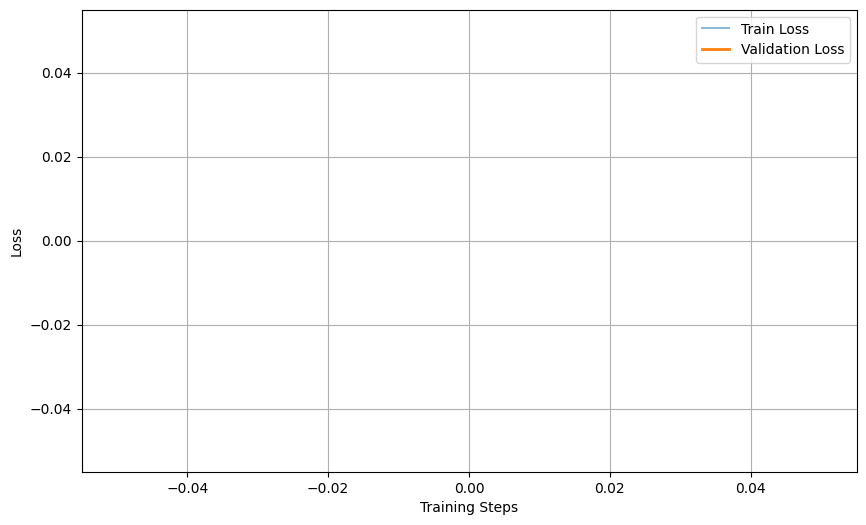

In [23]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', alpha=0.5)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Still trending downwards, only trained this for 20-30 minutes on my mac. 

Now we can try to see whether the SAE is picking up on something interesting.

In [ ]:
subset = val_ds.shuffle(seed=42).select(range(100))
positives = [x["text"] for x in subset if x["label"] == 1]
negatives = [x["text"] for x in subset if x["label"] == 0]

positives = [tokenizer.encode(x, return_tensors="pt") for x in positives]
negatives = [tokenizer.encode(x, return_tensors="pt") for x in negatives]

len(positives), len(negatives)

In [36]:
LAYER = N_LAYERS // 2  # maybe the middle is interesting

with torch.no_grad():
    positive_activations = [model(x.to(DEVICE), output_hidden_states=True).hidden_states[LAYER].reshape(-1, HIDDEN_SIZE) for x in tqdm(positives)]
    negative_activations = [model(x.to(DEVICE), output_hidden_states=True).hidden_states[LAYER].reshape(-1, HIDDEN_SIZE) for x in tqdm(negatives)]

    positive_activations = torch.cat(positive_activations, dim=0)
    negative_activations = torch.cat(negative_activations, dim=0)
    
    positive_indices, positive_values = sae.encode(positive_activations)
    negative_indices, negative_values = sae.encode(negative_activations)


In [81]:
positive_counts = torch.bincount(positive_indices.flatten(), minlength=HIDDEN_SIZE * 2)
negative_counts = torch.bincount(negative_indices.flatten(), minlength=HIDDEN_SIZE * 2)

sorted_indices = torch.sort(positive_counts + negative_counts, descending=True).indices


In [180]:
def highlight_feature_activations(text, feature_idx, model, sae, tokenizer, device="mps"):
    RESET = "\033[0m"
    def get_color(value):
        normalized = max(0.0, min(1.0, math.log(value + 1e-5)))
        
        text_red = int(30 + 225 * normalized)  # increased range (30-255)
        
        bg_red = 255
        bg_green = bg_blue = int(255 - (80 * normalized))  # doubled the reduction (255-175)
        
        return f"\033[48;2;{bg_red};{bg_green};{bg_blue}m\033[38;2;{text_red};0;0m"
    
    # Tokenize and get model outputs
    tokens = tokenizer.encode(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(tokens, output_hidden_states=True)
        hidden_states = outputs.hidden_states[LAYER]
        hidden_states = hidden_states.reshape(-1, model.config.hidden_size)
        indices, values = sae.encode(hidden_states)
        
        # Create feature mask
        feature_mask = (indices == feature_idx).any(dim=1)
        feature_values = torch.zeros_like(feature_mask, dtype=torch.float)
        for i, (idx, val) in enumerate(zip(indices, values)):
            if feature_idx in idx:
                feature_values[i] = val[idx == feature_idx].max()
    
    # Decode tokens and apply colors
    tokens = tokens[0].cpu().numpy()
    decoded = []
    for i, token in enumerate(tokens):
        word = tokenizer.decode([token])
        if feature_mask[i]:
            color = get_color(feature_values[i].item())
            decoded.append(f"{color}{word}{RESET}")
        else:
            decoded.append(word)
    
    return "".join(decoded)

def highlight_feature(text, feature_idx, model, sae, tokenizer, device="mps"):
    example_text = tokenizer.decode(text[0], skip_special_tokens=True)
    colored_text = highlight_feature_activations(example_text, feature_idx, model, sae, tokenizer)
    print(colored_text)

Now we can at last highlight the features.

The most common activations appear to "overfire" in this small example we have done. 

In [ ]:
highlight_feature(positives[1], sorted_indices[0], model, sae, tokenizer)
highlight_feature(negatives[1], sorted_indices[0], model, sae, tokenizer)

Some features I have naively labelled

"Referring to someone or something" feature

In [ ]:
highlight_feature(positives[2], sorted_indices[8], model, sae, tokenizer)
highlight_feature(negatives[2], sorted_indices[8], model, sae, tokenizer)

"End of sentence" feature

In [ ]:
highlight_feature(positives[3], sorted_indices[10], model, sae, tokenizer)
highlight_feature(negatives[3], sorted_indices[10], model, sae, tokenizer)

The "the" feature

In [ ]:
highlight_feature(positives[4], sorted_indices[14], model, sae, tokenizer)
highlight_feature(negatives[4], sorted_indices[14], model, sae, tokenizer)


"name" feature

In [ ]:
highlight_feature(positives[5], sorted_indices[16], model, sae, tokenizer)
highlight_feature(negatives[5], sorted_indices[16], model, sae, tokenizer)

"media" feature?

In [ ]:
highlight_feature(positives[6], sorted_indices[20], model, sae, tokenizer)
highlight_feature(negatives[6], sorted_indices[20], model, sae, tokenizer)

"<'br' /><'br' />" feature, for some reason it was not filtered out of the dataset

In [ ]:
highlight_feature(positives[7], sorted_indices[22], model, sae, tokenizer)
highlight_feature(negatives[7], sorted_indices[22], model, sae, tokenizer)

"counts of something" feature

In [ ]:
highlight_feature(positives[8], sorted_indices[24], model, sae, tokenizer)
highlight_feature(negatives[8], sorted_indices[24], model, sae, tokenizer)

"description of quality" feature

In [ ]:
highlight_feature(positives[9], sorted_indices[28], model, sae, tokenizer)
highlight_feature(negatives[9], sorted_indices[28], model, sae, tokenizer)

a "a" feature

In [ ]:
highlight_feature(positives[10], sorted_indices[30], model, sae, tokenizer)
highlight_feature(negatives[10], sorted_indices[30], model, sae, tokenizer)


This is the "this/these/that/those" feature

In [ ]:
highlight_feature(positives[11], sorted_indices[40], model, sae, tokenizer)
highlight_feature(negatives[11], sorted_indices[40], model, sae, tokenizer)